In [1]:
import os
import sys
import re
from pathlib import Path
from pprint import pprint

import numpy as np
from numpy.polynomial import Polynomial
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('Project:', PROJECT_ROOT)

# Define output directory for figures
output_dir = PROJECT_ROOT / "outputs" / "figures"
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory set to: {output_dir}")


Project: /Users/daisukeyamashiki/Code/Research/kyoto-flare-detection
Output directory set to: /Users/daisukeyamashiki/Code/Research/kyoto-flare-detection/outputs/figures


In [2]:
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime

# --- 論文用のスタイル設定 (Publication Ready) ---
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# Debug output directory (for cross-environment comparison)
_debug_stamp = datetime.now().strftime('%Y%m%d_%H%M%S')
DEBUG_DIR = output_dir / 'debug' / _debug_stamp
DEBUG_DIR.mkdir(parents=True, exist_ok=True)


def _dump_csv(path, header, rows):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open('w', encoding='utf-8') as f:
        f.write(header + "\n")
        for row in rows:
            f.write(','.join(str(x) for x in row) + "\n")


print("Publication style settings applied.")
print(f"Debug output dir: {DEBUG_DIR}")


Publication style settings applied.
Debug output dir: /Users/daisukeyamashiki/Code/Research/kyoto-flare-detection/outputs/figures/debug/20260206_185924


In [3]:
try:
    import src.flarepy_EK_Dra as ek_module
    import src.flarepy_V889_Her as v889_module
    import src.flarepy_DS_Tuc_A as ds_module
    # 他の星のモジュールも同様に追加
except ImportError as e:
    print(f"Error importing analyzer modules: {e}")
    print("Make sure the analyzer Python files (e.g., analyzer_EK_Dra.py) are in the correct path.")
    exit()


def normalize_star_folder_name(name: str) -> str:
    """フォルダ名・設定値の差異を吸収するため小文字英数字に正規化"""
    return re.sub(r"[^A-Za-z0-9]", "", name).lower()


# 2. 星の名前と、使用するFlareDetectorクラスをマッピングする辞書
#    キー: 正規化後の星フォルダ名 (Path.iterdir() の結果を normalize_star_folder_name で変換した値)
#    値: 対応するモジュール内の FlareDetector クラス
STAR_CLASS_MAP = {
    normalize_star_folder_name("EK_Dra"): ek_module.FlareDetector_EK_Dra,
    normalize_star_folder_name("V889_Her"): v889_module.FlareDetector_V889_Her,
    normalize_star_folder_name("DS_Tuc_A"): ds_module.FlareDetector_DS_Tuc_A,
    # 他の星も同様に追加: normalize_star_folder_name("StarFolderName"): corresponding_module.FlareDetector
}

# 3. 星のデータが格納されている親フォルダ
#    デフォルトでは data/TESS 配下を参照し、KYOTO_FLARE_STARS_DIR で上書き可能
DEFAULT_STARS_FOLDER = PROJECT_ROOT / "data" / "TESS"
BASE_STARS_FOLDER = Path(
    os.environ.get(
        "KYOTO_FLARE_STARS_DIR",
        str(DEFAULT_STARS_FOLDER),
    )
).expanduser()

# 4. 全ての星の解析結果を格納する辞書 (星の名前がキー)
all_stars_detectors = {}

# 5. 親フォルダ内の各星フォルダをループ
if not BASE_STARS_FOLDER.exists():
    print(f"Error: Base stars folder '{BASE_STARS_FOLDER}' not found.")
    exit()

for star_folder_path in sorted(BASE_STARS_FOLDER.iterdir()):
    if not star_folder_path.is_dir():  # フォルダでなければスキップ
        continue

    star_folder_name = star_folder_path.name
    normalized_star_name = normalize_star_folder_name(star_folder_name)

    # 6. この星に対応する FlareDetector クラスを取得
    if normalized_star_name not in STAR_CLASS_MAP:
        print(f"Warning: No FlareDetector class mapped for star folder '{star_folder_name}'. Skipping.")
        continue
    TargetFlareDetectorClass = STAR_CLASS_MAP[normalized_star_name]

    print(f"Processing star: {star_folder_name} (using {TargetFlareDetectorClass.__module__}.FlareDetector)")

    # 7. 特定の星のFlareDetectorインスタンスを格納するための辞書
    star_specific_detectors = {}

    # 星フォルダ内のファイルリスト (Path.glob を利用)
    file_list = sorted(star_folder_path.glob("*.fits"))

    for file_path in file_list:
        file_name_only = file_path.name
        s_number = None
        # ファイル名から "s" の後の4桁の数字を抽出 (例: s0001)
        for part in file_name_only.split("-"):
            if part.startswith("s") and len(part) >= 5 and part[1:5].isdigit():
                s_number = part[:5]
                break

        if s_number:
            instance_name = f"detector_{s_number}"
            try:
                # 8. 対応する FlareDetector クラスのインスタンスを作成
                #    引数は各 FlareDetector クラスの __init__ メソッドに合わせてください。
                #    ここでは共通のパラメータセットを仮定していますが、
                #    星ごとやクラスごとに異なるパラメータが必要な場合は、
                #    STAR_CLASS_MAP にパラメータ情報も持たせるなどの工夫が必要です。
                detector_params = {
                    "ene_thres_high": 1e39
                }
                detector = TargetFlareDetectorClass(
                    file=file_path,
                    process_data=True,
                    ene_thres_low=5e33,
                    **detector_params,
                )

                # データが有効かどうかの簡単なチェック
                if detector.tessBJD is not None and len(detector.tessBJD) > 0:
                    star_specific_detectors[instance_name] = detector
                else:
                    print(f"  Warning: No data or empty BJD for {file_path} in star {star_folder_name}")

            except Exception as e:
                print(f"  Error processing file {file_path} for star {star_folder_name}: {e}")
                continue  # エラーが発生したファイルはスキップ
        # else:
        #     print(f"  Info: Could not extract s_number from {file_name_only}")

    # 9. 星のインスタンス辞書が空でなければソートして格納
    if star_specific_detectors:
        try:
            sorted_star_detectors = dict(sorted(
                star_specific_detectors.items(),
                key=lambda x: x[1].tessBJD[0] if (x[1].tessBJD is not None and len(x[1].tessBJD) > 0) else float('inf')
            ))
            all_stars_detectors[star_folder_name] = sorted_star_detectors
        except IndexError:
            print(f"  Warning: Could not sort detectors for {star_folder_name} due to missing BJD data in some instances.")
            all_stars_detectors[star_folder_name] = star_specific_detectors  # ソートせずに格納
        except Exception as e:
            print(f"  Error during sorting detectors for {star_folder_name}: {e}")
            all_stars_detectors[star_folder_name] = star_specific_detectors  # ソートせずに格納

    else:
        print(f"  No valid FITS files processed or no s_number found for star: {star_folder_name}")

# 10. 結果の確認 (例)
print("--- Analysis Results ---")
for star_name_key, detectors_for_star_dict in all_stars_detectors.items():
    print(f"Star: {star_name_key}")
    if detectors_for_star_dict:
        for det_name, det_instance in detectors_for_star_dict.items():
            num_flares = 0
            if hasattr(det_instance, 'peaktime') and det_instance.peaktime is not None:
                num_flares = len(det_instance.peaktime)
            first_bjd_str = "N/A"
            if hasattr(det_instance, 'tessBJD') and det_instance.tessBJD is not None and len(det_instance.tessBJD) > 0:
                first_bjd_str = f"{det_instance.tessBJD[0]:.4f}"

            print(f"  {det_name}: First BJD = {first_bjd_str}, Number of flares = {num_flares}")
    else:
        print("No detectors successfully processed for this star.")


Processing star: DS_Tuc_A (using src.flarepy_DS_Tuc_A.FlareDetector)
Processing star: EK_Dra (using src.flarepy_EK_Dra.FlareDetector)
Processing star: V889_Her (using src.flarepy_V889_Her.FlareDetector)
--- Analysis Results ---
Star: DS_Tuc_A
  detector_s0001: First BJD = 1325.2988, Number of flares = 10
  detector_s0027: First BJD = 2036.2815, Number of flares = 13
  detector_s0028: First BJD = 2061.8541, Number of flares = 12
  detector_s0067: First BJD = 3126.6448, Number of flares = 9
  detector_s0068: First BJD = 3154.8702, Number of flares = 11
Star: EK_Dra
  detector_s0014: First BJD = 1683.3525, Number of flares = 18
  detector_s0015: First BJD = 1711.3631, Number of flares = 18
  detector_s0016: First BJD = 1738.6505, Number of flares = 11
  detector_s0021: First BJD = 1870.4359, Number of flares = 22
  detector_s0022: First BJD = 1900.3405, Number of flares = 11
  detector_s0023: First BJD = 1930.3293, Number of flares = 10
  detector_s0041: First BJD = 2419.9882, Number of f

In [4]:
print("\n--- DEBUG INFO: Checking Attributes ---")
if 'all_stars_detectors' in locals() and all_stars_detectors:
    try:
        # 辞書から最初の星の名前を取得
        first_star_name = next(iter(all_stars_detectors))
        first_star_detectors = all_stars_detectors[first_star_name]

        if first_star_detectors:
            # その星の最初のインスタンスを取得
            first_instance = next(iter(first_star_detectors.values()))
            print(f"List of attributes for one instance of star '{first_star_name}':")

            # インスタンスが持つ全ての属性名と、その中身（最初の50文字）を表示
            for attr in dir(first_instance):
                if not attr.startswith('__'): # 特殊な属性は無視
                    try:
                        value = getattr(first_instance, attr)
                        print(f"  - {attr}: {str(value)[:50]}") # 値を少しだけ表示
                    except Exception:
                        print(f"  - {attr}: (Could not get value)")

    except StopIteration:
        print("Could not find any stars or detectors to debug.")
    except Exception as e:
        print(f"An error occurred during debugging: {e}")
print("--- END DEBUG INFO ---\n")



--- DEBUG INFO: Checking Attributes ---
List of attributes for one instance of star 'DS_Tuc_A':
  - R_sunstar_ratio: 0.964
  - T_star: 5428
  - _ensure_class_arrays: <bound method BaseFlareDetector._ensure_class_arra
  - _get_star_intensity_ratio: <bound method BaseFlareDetector._get_star_intensit
  - _get_tess_response: <function BaseFlareDetector._get_tess_response at 
  - a_i: [ 0.02778515  0.06917411 -0.02534372  0.03917159  
  - amPDCSAPflux: [1.0010493 1.0015922 1.000371  ... 1.0076033 1.007
  - amPDCSAPfluxerr: [0.00039142 0.00039157 0.00039138 ... 0.0003921  0
  - apply_gap_correction: <bound method BaseFlareDetector.apply_gap_correcti
  - array_amplitude: [0.05703998 0.08224428 0.06294364 0.04056662 0.053
  - array_data_name: ['tess2018206045859-s0001' 'tess2020186164531-s002
  - array_energy_ave: []
  - array_energy_ratio: [5.58409305e+33 1.47422756e+34 1.31952265e+34 8.60
  - array_flare_number: [ 7.  9. 10.  5.  8.]
  - array_flare_ratio: [0.27937916 0.39052613 0.47549861 

DS Tuc: a = 1.38e-01 ± 6.48e-02, b = 0.65 ± 0.33
EK Dra: a = 1.82e-01 ± 8.59e-03, b = 1.11 ± 0.15
V889 Her: a = 3.46e-01 ± 4.44e-02, b = 0.71 ± 0.27


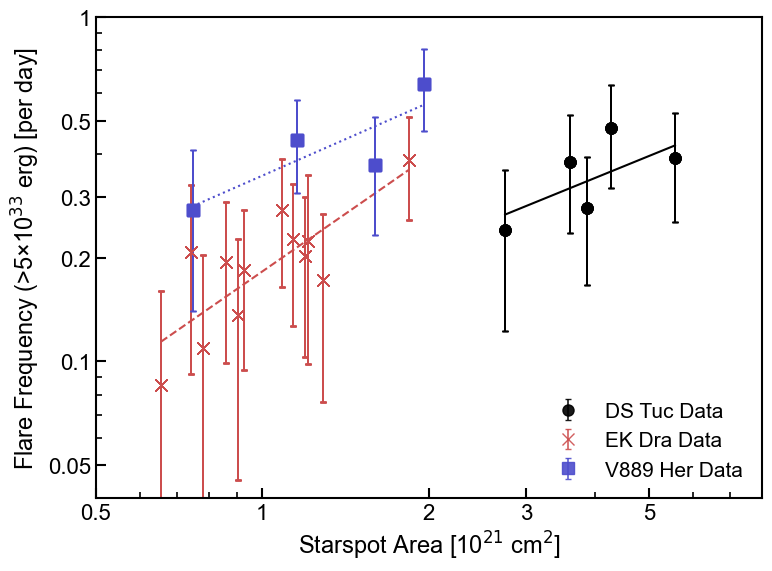

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit

# =========================
# 論文用のスタイル設定
# =========================
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# =========================
# 属性名（あなたがクラスに追加したやつ）
# =========================
x_axis_attribute = 'array_starspot'
n_axis_attribute = 'array_flare_number'
t_axis_attribute = 'array_precise_obs_time'
y_axis_attribute = 'array_flare_ratio'

# =========================
# 表示設定
# =========================
color_map = {
    'DS Tuc': 'black',
    'EK Dra': (0.8, 0.3, 0.3),
    'V889 Her': (0.3, 0.3, 0.8)
}
marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': 's'}
linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}

MARKER_SIZE = 8
CAPSIZE = 2
ELINEWIDTH = 1.2

def power_law(x, a, b):
    return a * x**b

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

# =========================
# メイン
# =========================
if 'all_stars_detectors' in globals() and all_stars_detectors:

    for star_key, detectors_dict in all_stars_detectors.items():
        display_name = star_key.replace('_', ' ').replace(' A', '')
        current_color = color_map.get(display_name, 'grey')
        current_marker = marker_map.get(display_name, 'o')
        current_linestyle = linestyle_map.get(display_name, '-')

        x_all, y_all, yerr_all = [], [], []

        for det in detectors_dict.values():
            if not (hasattr(det, x_axis_attribute) and hasattr(det, n_axis_attribute) and hasattr(det, t_axis_attribute)):
                continue

            x_arr = np.asarray(getattr(det, x_axis_attribute), dtype=float)
            N_arr = np.asarray(getattr(det, n_axis_attribute), dtype=float)
            T_arr = np.asarray(getattr(det, t_axis_attribute), dtype=float)

            if x_arr.size == 0 or N_arr.size == 0 or T_arr.size == 0:
                continue
            if not (len(x_arr) == len(N_arr) == len(T_arr)):
                print(f"[WARN] {display_name}: len(x)={len(x_arr)} len(N)={len(N_arr)} len(T)={len(T_arr)} 不一致でスキップ")
                continue

            y_calc = N_arr / T_arr
            yerr_arr = np.sqrt(N_arr + 1.0) / T_arr

            x_scaled = x_arr / 1e17
            mask = (
                np.isfinite(x_scaled) & np.isfinite(y_calc) & np.isfinite(yerr_arr) &
                (x_scaled > 0) & (y_calc > 0) & (T_arr > 0) & (N_arr >= 0)
            )

            if hasattr(det, y_axis_attribute):
                y_ref = np.asarray(getattr(det, y_axis_attribute), dtype=float)
                if y_ref.size == 0:
                    print(f"[CHECK] {display_name}: {y_axis_attribute} is empty")
                elif len(y_ref) != len(N_arr):
                    print(f"[CHECK] {display_name}: len({y_axis_attribute})={len(y_ref)} != len(N)={len(N_arr)}")
                else:
                    m = mask & np.isfinite(y_ref)
                    if np.any(m):
                        diff = y_calc[m] - y_ref[m]
                        abs_max = np.max(np.abs(diff))
                        if abs_max > 1e-10:
                            print("  head N:", N_arr[m][:5])
                            print("  head T:", T_arr[m][:5])
                            print("  head N/T:", y_calc[m][:5])
                            print(f"  head {y_axis_attribute}:", y_ref[m][:5])
                    else:
                        print(f"[CHECK] {display_name}: no valid points to compare (after mask)")

            if np.any(mask):
                x_all.append(x_scaled[mask])
                y_all.append(y_calc[mask])
                yerr_all.append(yerr_arr[mask])

        if len(x_all) == 0:
            continue

        x_all = np.concatenate(x_all)
        y_all = np.concatenate(y_all)
        yerr_all = np.concatenate(yerr_all)

        if len(x_all) < 2:
            continue

        # Dump debug CSV
        _dump_csv(
            DEBUG_DIR / f"freq_{display_name.replace(' ', '_')}.csv",
            "x_starspot_scaled,y_freq_per_day,yerr_per_day",
            zip(x_all, y_all, yerr_all),
        )

        ax.errorbar(
            x_all, y_all, yerr=yerr_all,
            fmt=current_marker, linestyle='None',
            color=current_color,
            markersize=MARKER_SIZE,
            capsize=CAPSIZE,
            elinewidth=ELINEWIDTH,
            alpha=0.9,
            label=f"{display_name} Data"
        )

        try:
            popt, pcov = curve_fit(
                power_law,
                x_all, y_all,
                sigma=yerr_all,
                absolute_sigma=True,
                maxfev=10000
            )

            a, b = popt
            a_err, b_err = np.sqrt(np.diag(pcov))

            x_fit = np.linspace(x_all.min(), x_all.max(), 200)
            y_fit = power_law(x_fit, a, b)

            ax.plot(x_fit, y_fit, color=current_color, linestyle=current_linestyle, label="_nolegend_")
            plot_successful = True

            # Dump fit line
            _dump_csv(
                DEBUG_DIR / f"freq_fit_{display_name.replace(' ', '_')}.csv",
                "x_fit,y_fit",
                zip(x_fit, y_fit),
            )

            print(f"{display_name}: a = {a:.2e} ± {a_err:.2e}, b = {b:.2f} ± {b_err:.2f}")
        except Exception as e:
            print(f"Could not perform power-law curve_fit for {display_name}: {e}")

    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel(r"Flare Frequency (>5×10$^{33}$ erg) [per day]", fontsize=17)

        ax.set_xlim(0.5, 8)
        ax.set_ylim(0.04, 1.0)

        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.set_yticks([0.05, 0.1, 0.2, 0.3, 0.5, 1.0])

        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:g}"))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y:g}"))

        ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
        ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())
        ax.yaxis.set_minor_formatter(mticker.NullFormatter())

        ax.tick_params(axis='both', which='both', direction='in', top=False, right=False)
        ax.tick_params(axis='both', which='major', length=7, width=1.5, labelsize=16)
        ax.tick_params(axis='both', which='minor', length=4, width=1.2)

        ax.legend(loc='lower right', fontsize=15, frameon=False)

        fig.tight_layout()
        plt.savefig(output_dir / 'analysis_result_freq_plot_integrated.pdf', bbox_inches='tight')
        plt.show()
    else:
        print("\nNo data was plotted (or no fit was successful).")

else:
    print("\nError: 'all_stars_detectors' dictionary not found or is empty.")


DS Tuc: a = 3.28e-01 ± 9.34e-02, b = 1.35 ± 0.19
EK Dra: a = 7.22e-01 ± 2.32e-02, b = 1.00 ± 0.09
V889 Her: a = 2.12e+00 ± 1.78e-01, b = 1.13 ± 0.15


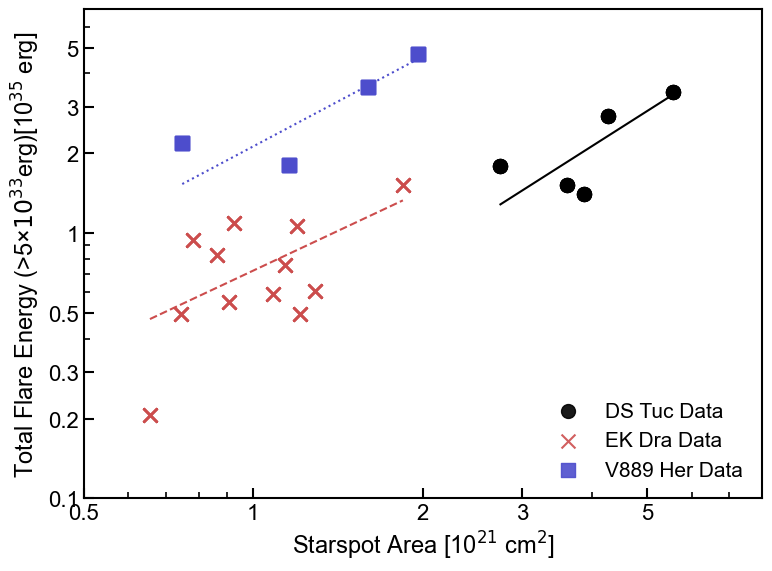

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- 論文用のスタイル設定 ---
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# --- ここからグラフ作成処理 ---

x_axis_attribute = 'array_starspot'
y_axis_attribute = 'array_sum_energy'

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    color_map = {'DS Tuc': 'black',
        'EK Dra': (0.8, 0.3, 0.3),
        'V889 Her': (0.3, 0.3, 0.8)
        }
    marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': 's'}
    marker_size = 100
    linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}

    for star_key, detectors_dict in all_stars_detectors.items():
        display_name = star_key.replace('_', ' ').replace(' A', '')
        current_color = color_map.get(display_name, 'grey')
        current_marker = marker_map.get(display_name, 'x')
        current_linestyle = linestyle_map.get(display_name, '-')
        x_data_for_star = []
        y_data_for_star = []

        for det_instance in detectors_dict.values():
            if hasattr(det_instance, x_axis_attribute) and hasattr(det_instance, y_axis_attribute):
                x_array = getattr(det_instance, x_axis_attribute)
                y_array = getattr(det_instance, y_axis_attribute)
                if isinstance(x_array, (list, np.ndarray)) and isinstance(y_array, (list, np.ndarray)) and len(x_array) == len(y_array):
                    x_data_for_star.extend(x_array)
                    y_data_for_star.extend(y_array)

        if len(x_data_for_star) > 1:
            x_data = np.array(x_data_for_star)
            y_data = np.array(y_data_for_star)
            x_data_scaled = x_data / 1e17
            y_data_scaled = y_data / 1e35

            _dump_csv(
                DEBUG_DIR / f"totalene_{display_name.replace(' ', '_')}.csv",
                "x_starspot_scaled,y_total_energy_scaled",
                zip(x_data_scaled, y_data_scaled),
            )

            ax.scatter(
                x_data_scaled, y_data_scaled,
                label=f'{display_name} Data',
                color=current_color,
                alpha=0.9,
                marker=current_marker,
                s=marker_size
            )

        from scipy.optimize import curve_fit

        def power_law(x, a, b):
            return a * x**b

        try:
            mask = (x_data_scaled > 0) & (y_data_scaled > 0)
            x_fit_data = x_data_scaled[mask]
            y_fit_data = y_data_scaled[mask]

            popt, pcov = curve_fit(power_law, x_fit_data, y_fit_data)

            a, b = popt
            a_err, b_err = np.sqrt(np.diag(pcov))

            x_fit = np.linspace(x_fit_data.min(), x_fit_data.max(), 200)
            y_fit = power_law(x_fit, a, b)

            _dump_csv(
                DEBUG_DIR / f"totalene_fit_{display_name.replace(' ', '_')}.csv",
                "x_fit,y_fit",
                zip(x_fit, y_fit),
            )

            ax.plot(x_fit, y_fit,
                    color=current_color,
                    linestyle=current_linestyle)

            plot_successful = True

            print(f"{display_name}: a = {a:.2e} ± {a_err:.2e}, b = {b:.2f} ± {b_err:.2f}")

        except Exception as e:
            print(f"Could not perform power-law curve_fit for {display_name}: {e}")

    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel("Total Flare Energy (>5×$10^{33}$erg)[10$^{35}$ erg]", fontsize=17)

        ax.set_xlim(0.5, 8)
        ax.set_ylim(0.1, 7)

        ax.set_yscale('log')
        ax.set_xscale('log')

        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.set_yticks([0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 3.0, 5.0])

        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:g}"))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y:g}"))

        ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
        ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())
        ax.yaxis.set_minor_formatter(mticker.NullFormatter())

        ax.tick_params(axis='both', which='both', direction='in', top=False, right=False)
        ax.tick_params(axis='both', which='major', length=7, width=1.5, labelsize=16)
        ax.tick_params(axis='both', which='minor', length=4, width=1.2)

        ax.legend(loc='lower right', fontsize=15, frameon=False)

        fig.tight_layout()
        plt.savefig(output_dir / 'analysis_result_totalene_plot_integrated.pdf', bbox_inches='tight')
        plt.show()
    else:
        print("\nNo data was plotted.")
else:
    print("\nError: 'all_stars_detectors' dictionary not found or is empty.")


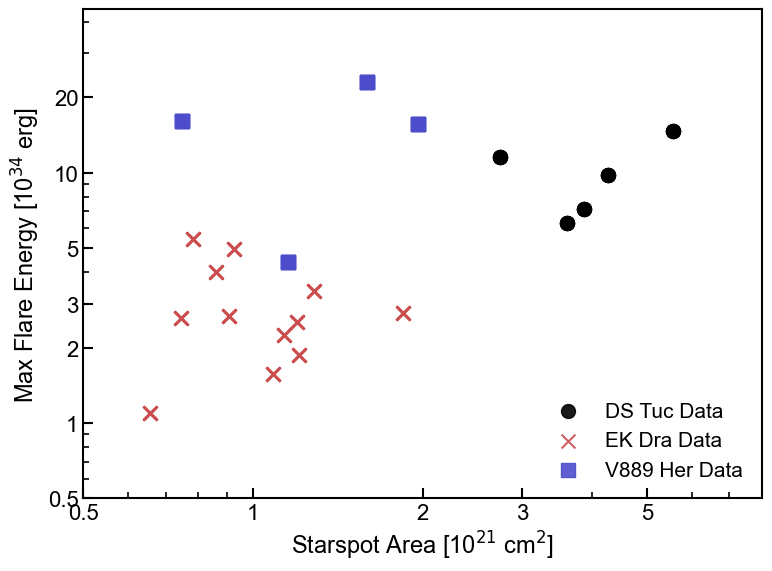

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- 論文用のスタイル設定 ---
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# --- ここからグラフ作成処理 ---

x_axis_attribute = 'array_starspot'
y_axis_attribute = 'array_max_energy'

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    color_map = {'DS Tuc': 'black',
        'EK Dra': (0.8, 0.3, 0.3),
        'V889 Her': (0.3, 0.3, 0.8)
        }
    marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': 's'}
    marker_size = 100
    linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}

    for star_key, detectors_dict in all_stars_detectors.items():
        display_name = star_key.replace('_', ' ').replace(' A', '')
        current_color = color_map.get(display_name, 'grey')
        current_marker = marker_map.get(display_name, 'x')
        current_linestyle = linestyle_map.get(display_name, '-')
        x_data_for_star = []
        y_data_for_star = []

        for det_instance in detectors_dict.values():
            if hasattr(det_instance, x_axis_attribute) and hasattr(det_instance, y_axis_attribute):
                x_array = getattr(det_instance, x_axis_attribute)
                y_array = getattr(det_instance, y_axis_attribute)
                if isinstance(x_array, (list, np.ndarray)) and isinstance(y_array, (list, np.ndarray)) and len(x_array) == len(y_array):
                    x_data_for_star.extend(x_array)
                    y_data_for_star.extend(y_array)

        if len(x_data_for_star) > 1:
            x_data = np.array(x_data_for_star)
            y_data = np.array(y_data_for_star)
            x_data_scaled = x_data / 1e17
            y_data_scaled = y_data / 1e34

            _dump_csv(
                DEBUG_DIR / f"maxene_{display_name.replace(' ', '_')}.csv",
                "x_starspot_scaled,y_max_energy_scaled",
                zip(x_data_scaled, y_data_scaled),
            )

            ax.scatter(
                x_data_scaled, y_data_scaled,
                label=f'{display_name} Data',
                color=current_color,
                alpha=0.9,
                marker=current_marker,
                s=marker_size
            )

            plot_successful = True

    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel("Max Flare Energy [10$^{34}$ erg]", fontsize=17)

        ax.set_xlim(0.5, 8)
        ax.set_ylim(0.5, 45)

        ax.set_yscale('log')
        ax.set_xscale('log')

        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.set_yticks([0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0])

        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:g}"))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y:g}"))

        ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
        ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())
        ax.yaxis.set_minor_formatter(mticker.NullFormatter())

        ax.tick_params(axis='both', which='both', direction='in', top=False, right=False)
        ax.tick_params(axis='both', which='major', length=7, width=1.5, labelsize=16)
        ax.tick_params(axis='both', which='minor', length=4, width=1.2)

        ax.legend(loc='lower right', fontsize=15, frameon=False)

        fig.tight_layout()
        plt.savefig(output_dir / 'analysis_result_maxene_plot_integrated.pdf', bbox_inches='tight')
        plt.show()
    else:
        print("\nNo data was plotted.")
else:
    print("\nError: 'all_stars_detectors' dictionary not found or is empty.")


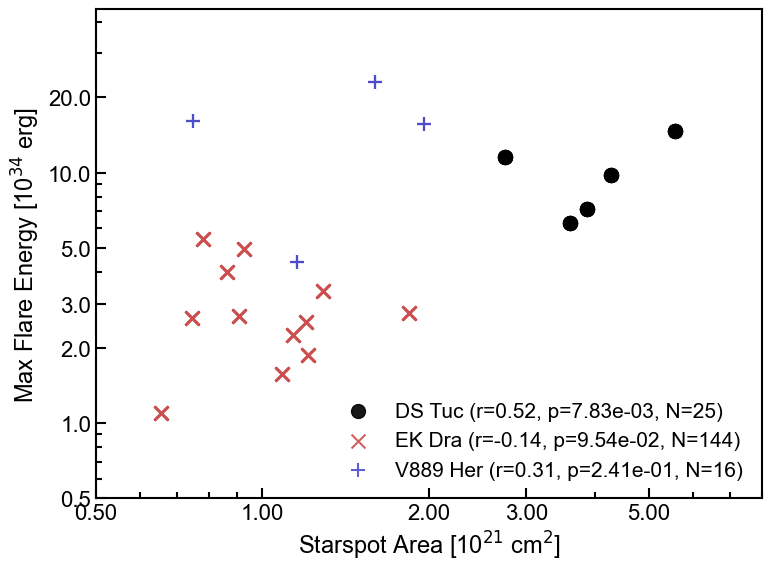

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import pearsonr

# --- 論文用のスタイル設定 ---
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# --- ここからグラフ作成処理 ---
x_axis_attribute = 'array_starspot'
y_axis_attribute = 'array_max_energy'

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    color_map = {
        'DS Tuc': 'black',
        'EK Dra': (0.8, 0.3, 0.3),
        'V889 Her': (0.3, 0.3, 0.8)
    }
    marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': '+'}
    marker_size = 100
    linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}

    for star_key, detectors_dict in all_stars_detectors.items():
        display_name = star_key.replace('_', ' ').replace(' A', '')
        current_color = color_map.get(display_name, 'grey')
        current_marker = marker_map.get(display_name, 'x')

        x_data_for_star = []
        y_data_for_star = []

        for det_instance in detectors_dict.values():
            if hasattr(det_instance, x_axis_attribute) and hasattr(det_instance, y_axis_attribute):
                x_array = getattr(det_instance, x_axis_attribute)
                y_array = getattr(det_instance, y_axis_attribute)

                if isinstance(x_array, (list, np.ndarray)) and isinstance(y_array, (list, np.ndarray)) and len(x_array) == len(y_array):
                    x_data_for_star.extend(x_array)
                    y_data_for_star.extend(y_array)

        if len(x_data_for_star) > 1:
            x_data = np.array(x_data_for_star, dtype=float)
            y_data = np.array(y_data_for_star, dtype=float)

            valid = np.isfinite(x_data) & np.isfinite(y_data)
            x_data = x_data[valid]
            y_data = y_data[valid]

            x_data_scaled = x_data / 1e17
            y_data_scaled = y_data / 1e34

            _dump_csv(
                DEBUG_DIR / f"maxene_pearson_{display_name.replace(' ', '_')}.csv",
                "x_starspot_scaled,y_max_energy_scaled",
                zip(x_data_scaled, y_data_scaled),
            )

            r_str, p_str = "NA", "NA"
            if len(x_data_scaled) >= 2:
                if np.nanstd(x_data_scaled) > 0 and np.nanstd(y_data_scaled) > 0:
                    try:
                        r, p = pearsonr(x_data_scaled, y_data_scaled)
                        r_str = f"{r:.2f}"
                        p_str = f"{p:.2e}"
                    except Exception:
                        pass

            label = f"{display_name} (r={r_str}, p={p_str}, N={len(x_data_scaled)})"

            ax.scatter(
                x_data_scaled,
                y_data_scaled,
                label=label,
                color=current_color,
                alpha=0.9,
                marker=current_marker,
                s=marker_size
            )

            plot_successful = True

    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel("Max Flare Energy [10$^{34}$ erg]", fontsize=17)

        ax.set_xlim(0.5, 8)
        ax.set_ylim(0.5, 45)

        ax.set_yscale('log')
        ax.set_xscale('log')

        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())

        ax.set_yticks([0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0])
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

        ax.legend(loc='lower right', fontsize=15, frameon=False)
        ax.tick_params(axis='both', which='major', labelsize=16)

        fig.tight_layout()
        # plt.savefig(output_dir / 'analysis_result_maxene_plot_pearsonr.pdf', bbox_inches='tight')
        plt.show()
    else:
        print("\nNo data was plotted.")
else:
    print("\nError: 'all_stars_detectors' dictionary not found or is empty.")


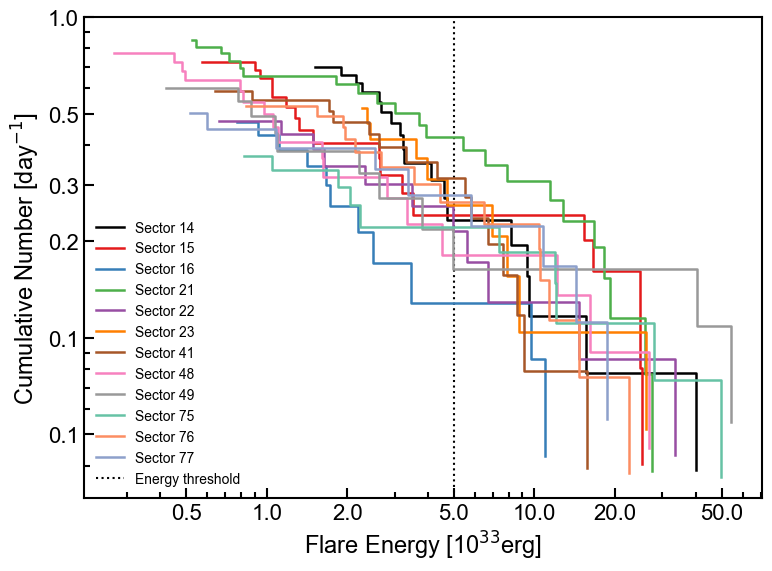

In [9]:
# Cumulative Flare Energy - EK Dra

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ===============================
# 論文用スタイル設定（そのまま流用）
# ===============================
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# ===============================
# データ取得
# ===============================
if 'EK_Dra' in all_stars_detectors:
    detector_items = list(all_stars_detectors["EK_Dra"].items())
else:
    detector_items = []

colors = [
    "#000000", "#E41A1C", "#377EB8", "#4DAF4A",
    "#984EA3", "#FF7F00", "#A65628", "#F781BF",
    "#999999", "#66C2A5", "#FC8D62", "#8DA0CB",
]

# ===============================
# Figure 作成
# ===============================
fig, ax = plt.subplots(figsize=(8, 6))

# ===============================
# 各インスタンスを描画
# ===============================
for i, (det_name, det) in enumerate(detector_items):
    if det.energy is None or len(det.energy) == 0:
        continue

    color = colors[i % len(colors)]

    energy_cor = np.sort(det.energy)
    cumenergy = np.array([len(energy_cor) - j for j in range(len(energy_cor))])
    rate = cumenergy / det.precise_obs_time

    try:
        s = det_name.split("_")[-1]
        sector_num = int(s[1:])
        label = f"Sector {sector_num}"
    except Exception:
        label = det_name

    _dump_csv(
        DEBUG_DIR / f"cumenergy_EKDra_{label.replace(' ', '_')}.csv",
        "energy_erg,rate_per_day",
        zip(energy_cor, rate),
    )

    ax.step(
        energy_cor / 1e33,
        rate,
        where="post",
        color=color,
        linewidth=1.8,
        label=label,
    )

# ===============================
# 軸設定（論文向け）
# ===============================
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Flare Energy [10$^{33}$erg]", fontsize=17)
ax.set_ylabel(r"Cumulative Number [day$^{-1}$]", fontsize=17)

ax.tick_params(labelsize=16)

ax.axvline(
    x=5,
    color="black",
    linestyle="dotted",
    linewidth=1.5,
    label="Energy threshold",
    zorder=0
)

ax.set_xticks([0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0])
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_formatter(mticker.NullFormatter())

ax.set_yticks([0.05, 0.1, 0.2, 0.3, 0.5, 1])
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# ===============================
# Legend（枠なし）
# ===============================
leg = ax.legend(
    loc="lower left",
    fontsize=10,
    frameon=True,
)
leg.get_frame().set_alpha(0)

# ===============================
# 保存・表示
# ===============================
plt.tight_layout()
plt.savefig(output_dir / 'flare_cumenergy_EKDra.pdf', format='pdf', bbox_inches='tight')
plt.show()


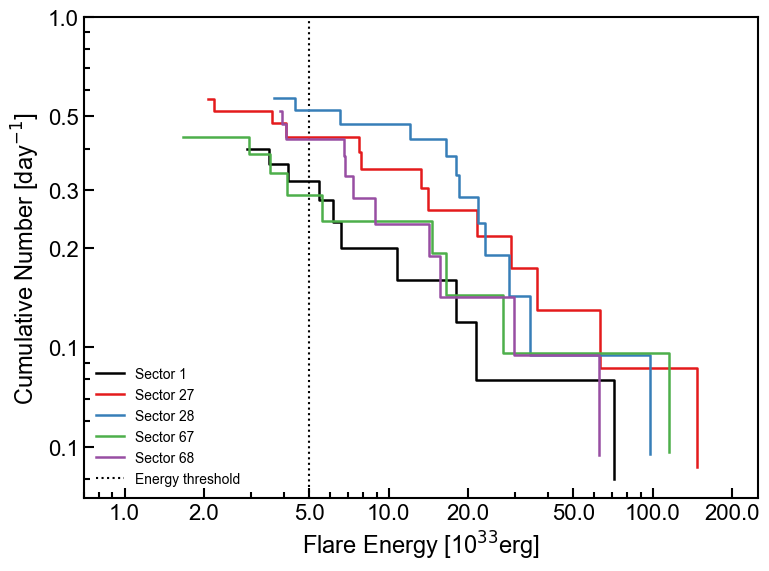

In [10]:
# Cumulative Flare Energy - DS Tuc

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ===============================
# 論文用スタイル設定（そのまま流用）
# ===============================
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# ===============================
# データ取得
# ===============================
if 'DS_Tuc_A' in all_stars_detectors:
    detector_items = list(all_stars_detectors["DS_Tuc_A"].items())
else:
    detector_items = []

colors = [
    "#000000", "#E41A1C", "#377EB8", "#4DAF4A",
    "#984EA3"
]

# ===============================
# Figure 作成
# ===============================
fig, ax = plt.subplots(figsize=(8, 6))

# ===============================
# 各インスタンスを描画
# ===============================
for i, (det_name, det) in enumerate(detector_items):
    if det.energy is None or len(det.energy) == 0:
        continue

    color = colors[i % len(colors)]

    energy_cor = np.sort(det.energy)
    cumenergy = np.array([len(energy_cor) - j for j in range(len(energy_cor))])
    rate = cumenergy / det.precise_obs_time

    try:
        s = det_name.split("_")[-1]
        sector_num = int(s[1:])
        label = f"Sector {sector_num}"
    except Exception:
        label = det_name

    _dump_csv(
        DEBUG_DIR / f"cumenergy_DSTuc_{label.replace(' ', '_')}.csv",
        "energy_erg,rate_per_day",
        zip(energy_cor, rate),
    )

    ax.step(
        energy_cor / 1e33,
        rate,
        where="post",
        color=color,
        linewidth=1.8,
        label=label,
    )

# ===============================
# 軸設定（論文向け）
# ===============================
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Flare Energy [10$^{33}$erg]", fontsize=17)
ax.set_ylabel(r"Cumulative Number [day$^{-1}$]", fontsize=17)

ax.tick_params(labelsize=16)

ax.axvline(
    x=5,
    color="black",
    linestyle="dotted",
    linewidth=1.5,
    label="Energy threshold",
    zorder=0
)

ax.set_xticks([1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100, 200])
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_formatter(mticker.NullFormatter())

ax.set_yticks([0.05 , 0.1 , 0.2 , 0.3 , 0.5 , 1 ])
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

ax.set_xlim(0.7, 250)

# ===============================
# Legend（枠なし）
# ===============================
leg = ax.legend(
    loc="lower left",
    fontsize=10,
    frameon=True,
)
leg.get_frame().set_alpha(0)

# ===============================
# 保存・表示
# ===============================
plt.tight_layout()
plt.savefig(output_dir / 'flare_cumenergy_DSTuc.pdf', format='pdf', bbox_inches='tight')
plt.show()


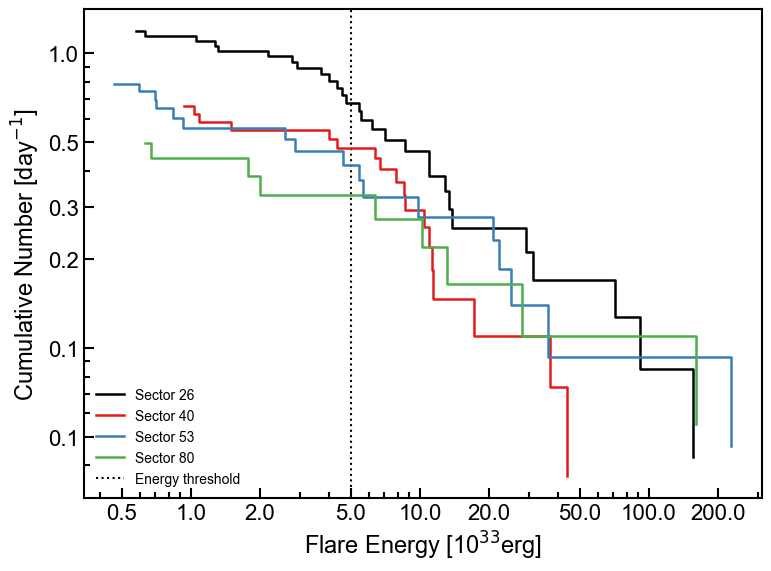

In [11]:
# Cumulative Flare Energy - V889 Her

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ===============================
# 論文用スタイル設定（そのまま流用）
# ===============================
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# ===============================
# データ取得
# ===============================
if 'V889_Her' in all_stars_detectors:
    detector_items = list(all_stars_detectors["V889_Her"].items())
else:
    detector_items = []

colors = [
    "#000000", "#E41A1C", "#377EB8", "#4DAF4A"
]

# ===============================
# Figure 作成
# ===============================
fig, ax = plt.subplots(figsize=(8, 6))

# ===============================
# 各インスタンスを描画
# ===============================
for i, (det_name, det) in enumerate(detector_items):
    if det.energy is None or len(det.energy) == 0:
        continue

    color = colors[i % len(colors)]

    energy_cor = np.sort(det.energy)
    cumenergy = np.array([len(energy_cor) - j for j in range(len(energy_cor))])
    rate = cumenergy / det.precise_obs_time

    try:
        s = det_name.split("_")[-1]
        sector_num = int(s[1:])
        label = f"Sector {sector_num}"
    except Exception:
        label = det_name

    _dump_csv(
        DEBUG_DIR / f"cumenergy_V889Her_{label.replace(' ', '_')}.csv",
        "energy_erg,rate_per_day",
        zip(energy_cor, rate),
    )

    ax.step(
        energy_cor / 1e33,
        rate,
        where="post",
        color=color,
        linewidth=1.8,
        label=label,
    )

# ===============================
# 軸設定（論文向け）
# ===============================
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Flare Energy [10$^{33}$erg]", fontsize=17)
ax.set_ylabel(r"Cumulative Number [day$^{-1}$]", fontsize=17)

ax.tick_params(labelsize=16)

ax.axvline(
    x=5,
    color="black",
    linestyle="dotted",
    linewidth=1.5,
    label="Energy threshold",
    zorder=0
)

ax.set_xticks([0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100, 200])
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_formatter(mticker.NullFormatter())

ax.set_yticks([0.05 , 0.1 , 0.2 , 0.3 , 0.5 , 1 ])
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# ===============================
# Legend（枠なし）
# ===============================
leg = ax.legend(
    loc="lower left",
    fontsize=10,
    frameon=True,
)
leg.get_frame().set_alpha(0)

# ===============================
# 保存・表示
# ===============================
plt.tight_layout()
plt.savefig(output_dir / 'flare_cumenergy_V889Her.pdf', format='pdf', bbox_inches='tight')
plt.show()
